# Introduction to Deep Learning

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.

[Homework #3](https://colab.research.google.com/drive/1OHcUdnSZwb5q84bgi3TRJ85udMgxmEuA) associated with this practice session is due **October 16 midnight (23:59 EET time)**.

# Convolutional Neural Networks
## Keras on CIFAR10

In this part of the class, we will examine convolutional neural networks (CNN). As CNNs were designed specifically to work with imaging data,  we will use CIFAR-10 dataset to demonstrate their effectiveness on images. The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60 000 pictures divided into 10 classes (hence the name CIFAR-10). Classes include common objects such as airplanes, automobiles, birds, cats and so on. Our goal is to train a convolutional neural network to classify these images.

The following instructions help to install required dependencies and load the data.

In [ ]:
# A bit of setup again
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR10
from tensorflow.keras.datasets import cifar10

# Keras comes with built-in loaders for common datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# shorten dataset for quicker training
X_train = X_train[:25000]
y_train = y_train[:25000]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Let's visualise several random images from each class to get familiar with the data:

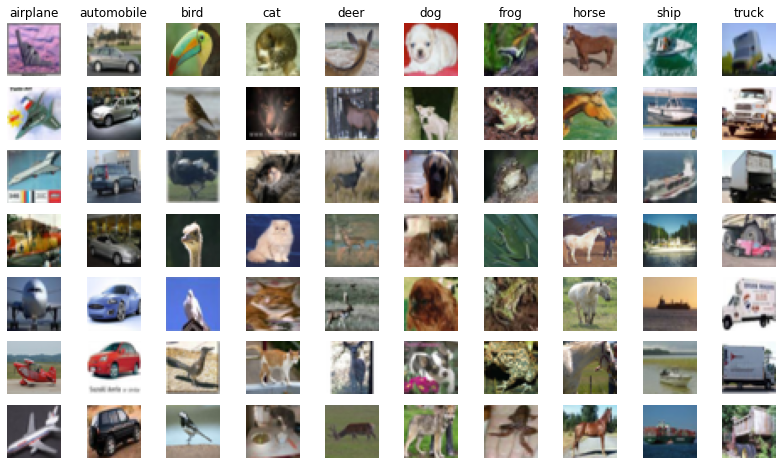

In [ ]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(class_names)

samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Do all images look right? Is there anything unexpected?

Building an effective neural network model requires careful consideration of the network architecture as well as the input data format. What do the 4 dimensions ((25000, 32, 32, 3)) of X_train represent? What values do these data contain and from what range do these values come from?

**Data normalisation step.** Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation [[source](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258)]. In our case we do it for each RGB component separately.

In [ ]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

Now we are ready to define our Convolutional Neural Network model. First we need to specify the layers that we will be using.

Here is the architecture that we shall use:

1. 3x3 convolution with 32 filters, stride 1, padding same
2. batch normalization
3. relu
4. 3x3 convolution with 32 filters, stride 1, padding valid
5. batch normalization
6. relu
7. max pooling 2x2
8. dropout 0.25
7. flatten
8. dense 100
5. batch normalization
6. relu
8. dropout 0.5
8. dense 10
9. softmax

You can consult Keras documentation for layer parameters:
 - [Convolutional layers](https://keras.io/layers/convolutional/)
 - [Pooling layers](https://keras.io/layers/pooling/)
 - [Normalization layers](https://keras.io/layers/normalization/)

Here is how aforementioned architecture can be implemented in Keras. Note the difference in notation with network we defined earlier: here we explicitely specify input and output of each layer.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)

Describe shortly what are Conv2D, BatchNormalization, Dropout and Dense? 

Now that we have defined the arhitecture, we can create a model simply by saying what is the input and what is output. Cross-entropy loss is applied to the network with Adam optimizer and additional accuracy metric.
**`sparse_categorical_crossentropy`** loss allows us to pass integer class values directly as targets and is potentially more efficient than categorical_crossentropy, which needs one-hot vectors as targets.

`model.summary()` prints out layer list with output shapes and is very useful for debugging the model. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let's train this convolutional neural network on CIFAR10, `validation_split` defines the number of data rows that will be used for validation. 

In [ ]:
# Fit the model; returns History object
history = model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
352/352 [==============================] - 13s 7ms/step - loss: 1.6655 - accuracy: 0.4160 - val_loss: 1.2812 - val_accuracy: 0.5472
Epoch 2/20
352/352 [==============================] - 2s 6ms/step - loss: 1.2694 - accuracy: 0.5488 - val_loss: 1.0682 - val_accuracy: 0.6224
Epoch 3/20
352/352 [==============================] - 2s 6ms/step - loss: 1.1281 - accuracy: 0.6050 - val_loss: 1.0223 - val_accuracy: 0.6340
Epoch 4/20
352/352 [==============================] - 2s 6ms/step - loss: 1.0161 - accuracy: 0.6423 - val_loss: 0.9723 - val_accuracy: 0.6568
Epoch 5/20
352/352 [==============================] - 2s 6ms/step - loss: 0.9414 - accuracy: 0.6636 - val_loss: 0.9467 - val_accuracy: 0.6704
Epoch 6/20
352/352 [==============================] - 2s 6ms/step - loss: 0.8750 - accuracy: 0.6929 - val_loss: 0.9720 - val_accuracy: 0.6636
Epoch 7/20
352/352 [==============================] - 2s 6ms/step - loss: 0.8393 - accuracy: 0.7074 - val_loss: 0.9168 - val_accuracy: 0.6820
Epoch

What do concepts such as **batch** and **epoch** stand for?

The following graphs illustrate the behaviour of Loss and Accuracy during the training process.

Text(0.5, 1.0, 'Accuracy')

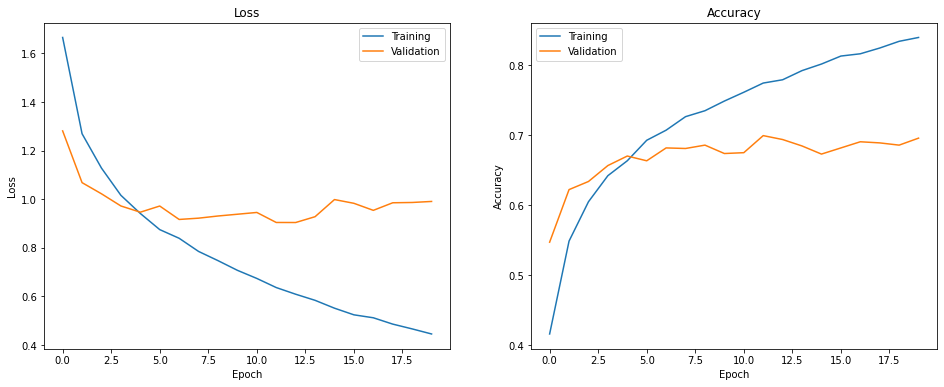

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

Next we will evaluate our trained network on the test and training data.

In [ ]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0101 - accuracy: 0.6778


[1.0101009607315063, 0.6777999997138977]

In [ ]:
# the same for training set
model.evaluate(X_train_norm, y_train)

782/782 [==============================] - 2s 3ms/step - loss: 0.2455 - accuracy: 0.9419


[0.24545316398143768, 0.9419199824333191]

Based on the training and test accuracy, is the trained network good?

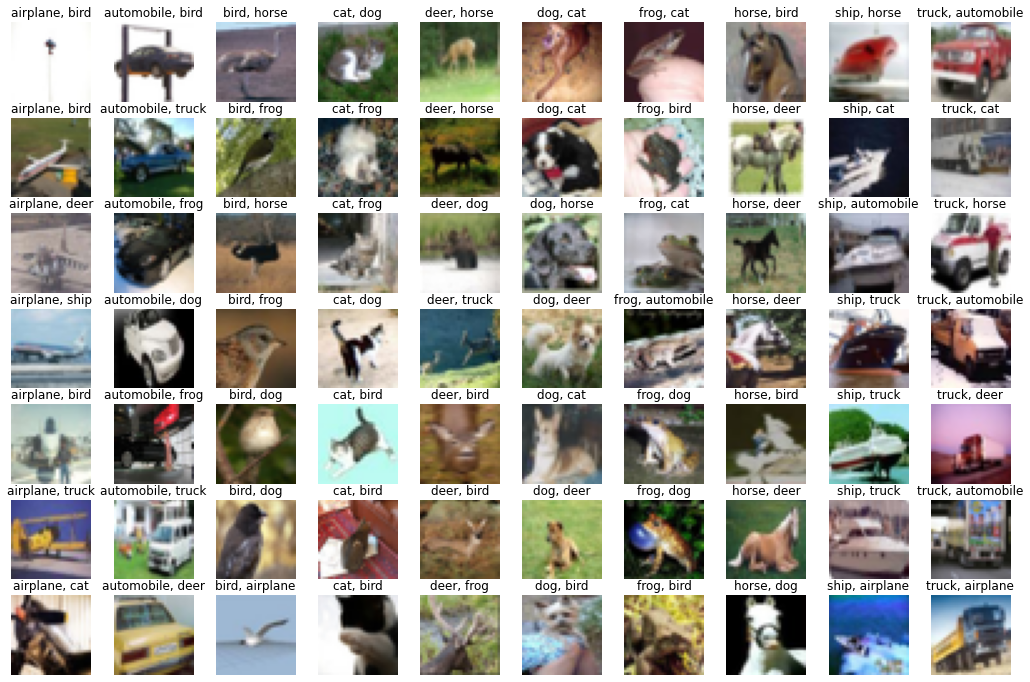

In [ ]:
test_predicted = np.argmax(model.predict(X_test_norm), axis=1)

plt.rcParams['figure.figsize'] = (18.0, 12.0) # set default size of plots
# "Names" of classes:
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)   

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(classes[y]) + ", " + str(classes[np.array(test_predicted)[idxs[idx]]]))
plt.show()

## CNN on MNIST
Let's use one of the convolutional neural networks we defined above to classify MNIST.

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Train images are of shape: {X_train.shape} and labels: {y_train.shape}")
print(f"Test images are of shape: {X_test.shape} and labels: {y_test.shape}")

11501568/11490434 [==============================] - 0s 0us/step
Train images are of shape: (60000, 28, 28) and labels: (60000,)
Test images are of shape: (10000, 28, 28) and labels: (10000,)


Copy and paste below one of the convolutional neural networks we have defined previously.


NB! Make sure the input shape is correct (recall that MNIST is 28x28x1 not 32x32x3 as CIFAR10).

In [ ]:
##### YOUR CODE STARTS #####
x = x = Input(shape=(28, 28, 1))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)

##### YOUR CODE ENDS ##### 

Compile and train your model, keep the record of loss in the `history` variable.

In [ ]:
##### YOUR CODE STARTS #####
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1)
##### YOUR CODE ENDS ##### 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                           

Visualise the training and validation accuracy and loss dynamics over epochs.

Text(0.5, 1.0, 'Accuracy')

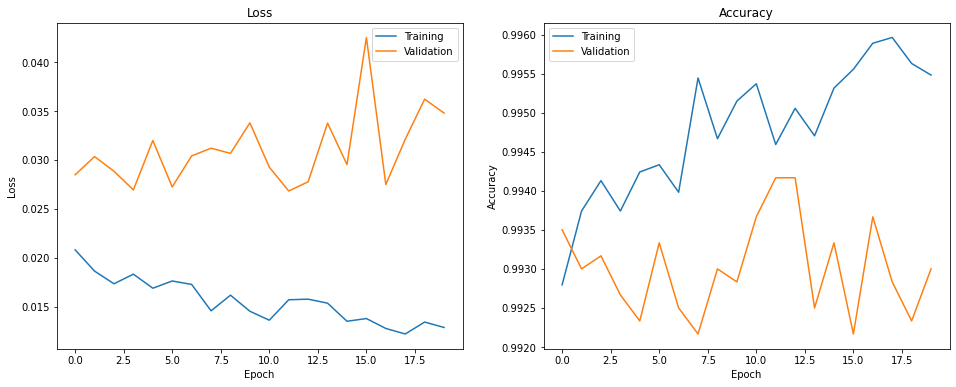

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

Does our network overfit? Does it have enough power to solve the problem?

Evaluate model on test images

In [ ]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0305 - accuracy: 0.9922


[0.030496597290039062, 0.9922000169754028]

Here we visualise misclassified examples for CNN on MNIST dataset: 

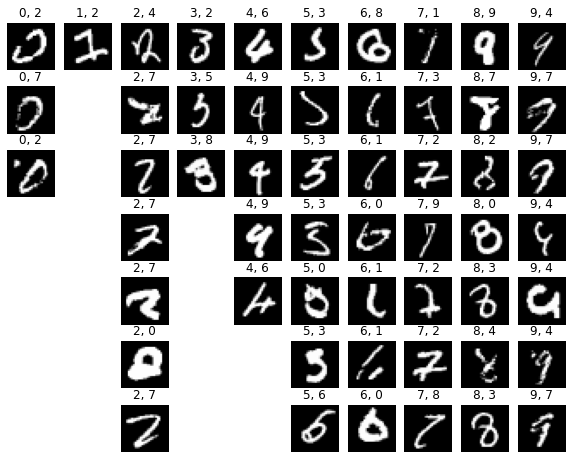

In [ ]:
test_predicted = np.argmax(model.predict(X_test), axis=1)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# "Names" of classes:
classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)   

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((28, 28)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(y) + ", " + str(np.array(test_predicted)[idxs[idx]]))
plt.show()

Do misclassifications look reasonable? 

# Fast.ai library

What is [fast.ai](https://docs.fast.ai/)?

Basically fast.ai is Keras on top of Pytorch that uses cutting edge research in Deep Learning.

**Why to introduce yet another library for DL in this class?**
* want to mention fast.ai online course which is great (it does not require you to use fast.ai library)
* image scraping exercise in the end of this class 
* fast.ai are usually the first to implement SOTA techniques (e.g. learning rate finder), and thus thier library usually provides cutting edge results in many domains

**Bad things about fast.ai (why my team don't use fast.ai):**
* if you want to change something or apply fast.ai in a custom way to custom data, the chances are high - it is going to be painful, why? ->
* the documentation is really bad, unless you are Jeremy Howard who has written it

In [ ]:
!pip install fastai==1.0.61

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 239 kB 9.8 MB/s 
     |████████████████████████████████| 355 kB 64.8 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=38972723ba03024d8a8b3ccca9b9ff576bcd24422338c90f8b97a3e858ca1973
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9


## fast.ai on CIFAR10

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

path = untar_data(URLs.CIFAR); path 
data = ImageDataBunch.from_folder(path, valid_pct = 0.1, size=48)
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.177916,0.993865,0.653667,01:00
1,0.816958,0.740114,0.742333,00:59
2,0.721728,0.672110,0.763333,00:59


## fast.ai on MNIST

In [ ]:
path = untar_data(URLs.MNIST); path
data = ImageDataBunch.from_folder(path, valid_pct=0.1, size=48)
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.266691,0.173800,0.945571,01:09
1,0.119322,0.073084,0.977429,01:09
2,0.088006,0.059957,0.981143,01:08


## Creating your own dataset using fast.ai
*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

### Get a list of URLs

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.src).filter(txt=> txt.slice(0,4) !== 'data');
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

After both files are downloaded and renamed, upload them to colab by running the following command

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving marigolds.csv to marigolds.csv


In [ ]:
!ls

marigolds.csv  sample_data


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pansies.csv to pansies.csv


In [ ]:
!ls

marigolds.csv  pansies.csv  sample_data


### Create directory and upload urls file into your server
Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
folder = 'marigolds'
file = 'marigolds.csv'

In [ ]:
path = Path('data/cats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
folder = 'pansies'
file = 'pansies.csv'

In [ ]:
path = Path('data/cats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

[PosixPath('data/cats/pansies'), PosixPath('data/cats/marigolds')]

## Download images
Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

In [ ]:
folder = 'marigolds'
dest = path/folder
download_images('marigolds.csv', dest, max_pics=400)

In [ ]:
folder = 'pansies'
dest = path/folder
download_images('pansies.csv', dest, max_pics=400)

In [ ]:
classes = ['marigolds','pansies']

Then we can remove any images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

marigolds


pansies


## View data

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data.classes

['marigolds', 'pansies']

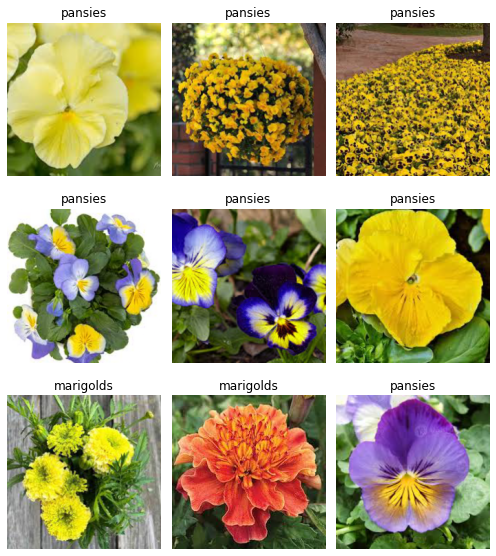

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['marigolds', 'pansies'], 2, 606, 151)

## Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.662397,0.251879,0.933775,00:05
1,0.391367,0.115960,0.966887,00:05
2,0.255989,0.097350,0.966887,00:04
3,0.200707,0.092239,0.966887,00:04
4,0.167010,0.094725,0.966887,00:04


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

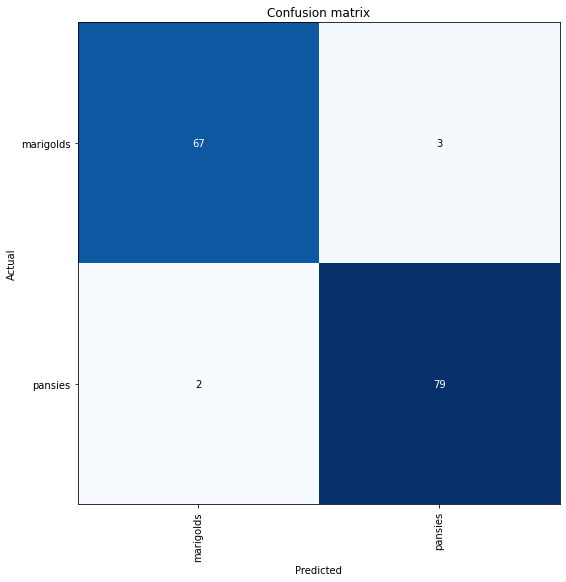

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
!ls $path/'marigolds'/

00000000.jpg  00000076.jpg  00000152.jpg  00000228.jpg	00000304.jpg
00000001.jpg  00000077.jpg  00000153.jpg  00000229.jpg	00000305.jpg
00000002.jpg  00000078.jpg  00000154.jpg  00000230.jpg	00000306.jpg
00000003.jpg  00000079.jpg  00000155.jpg  00000231.jpg	00000307.jpg
00000004.jpg  00000080.jpg  00000156.jpg  00000232.jpg	00000308.jpg
00000005.jpg  00000081.jpg  00000157.jpg  00000233.jpg	00000309.jpg
00000006.jpg  00000082.jpg  00000158.jpg  00000234.jpg	00000310.jpg
00000007.jpg  00000083.jpg  00000159.jpg  00000235.jpg	00000311.jpg
00000008.jpg  00000084.jpg  00000160.jpg  00000236.jpg	00000312.jpg
00000009.jpg  00000085.jpg  00000161.jpg  00000237.jpg	00000313.jpg
00000010.jpg  00000086.jpg  00000162.jpg  00000238.jpg	00000314.jpg
00000011.jpg  00000087.jpg  00000163.jpg  00000239.jpg	00000315.jpg
00000012.jpg  00000088.jpg  00000164.jpg  00000240.jpg	00000316.jpg
00000013.jpg  00000089.jpg  00000165.jpg  00000241.jpg	00000317.jpg
00000014.jpg  00000090.jpg  00000166.jpg  000002

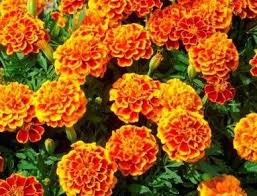

In [ ]:
img = open_image(path/'marigolds'/'00000011.jpg')
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'marigolds'

Get a url on the pansy image from internet and insert it below

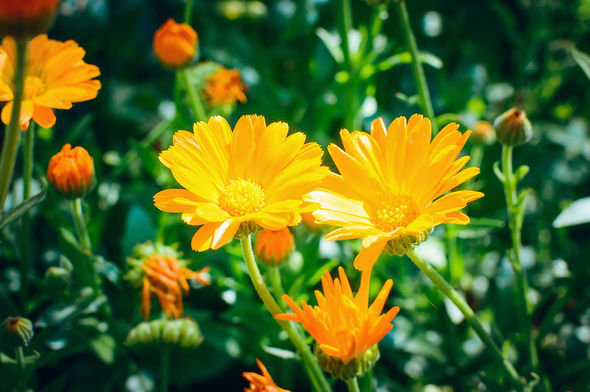

In [ ]:
from urllib.request import urlopen

img = open_image(urlopen('https://cdn.images.express.co.uk/img/dynamic/13/590x/secondary/when-to-plant-out-marigolds-3055211.jpg?r=1621521552828'))
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'marigolds'

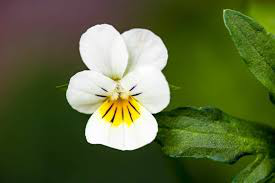

In [ ]:
img = open_image(urlopen('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSwiJ31yL4vVzzyRx7p0XO488eukd4P-jzeCA&usqp=CAU'))
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'pansies'

# References
* A very large part of this notebook has been inspired by http://cs231n.github.io/neural-networks-case-study/ developed by karpathy@cs.stanford.edu.
* CIFAR10 part of this practice has been inspired by the Machine Learning course taught at the University of Tartu by Meelis Kull (https://courses.cs.ut.ee/2019/ml/fall)
* Fast.ai part has been copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb. My general recommendation for everyone intersted in Deep Learning (not only in fast.ai library) to take fast.ai  online course for coders: https://course.fast.ai/ developed by Jeremy Howard et al.